# Market Basket Analysis

- Using Apriori Algorithm
- Opensource Retail Datset : Reference (http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx)

In [1]:
#Importing Libraries
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt
%matplotlib inline

#Loading Dataset 
data = pd.read_excel('http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [2]:
#check data types and null values
data_null = pd.DataFrame(data.dtypes).T.rename(index={0:'column_type'})
data_null = data_null.append(pd.DataFrame(data.isnull().sum()).T.rename(index={0:'Null_values'}))
data_null = data_null.append(pd.DataFrame(data.isnull().sum()/data.shape[0]*100).T.rename(index={0:'Null_values(%)'}))
data_null

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column_type,object,object,object,int64,datetime64[ns],float64,float64,object
Null_values,0,0,1454,0,0,0,135080,0
Null_values(%),0,0,0.268311,0,0,0,24.9267,0


In [3]:
#Fill missing values 
data['CustomerID'] = data['CustomerID'].fillna('00000')
data['Description'] = data['Description'].fillna('Un_Known')

#Stats Description of Numerical values - Quantity and UnitPrice
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0


In [4]:
#Errornous values - as quantity and Unit price have negative values
neg_quantity = len(data[data['Quantity'] <= 0])/ float(len(data))*100
zero_price = len(data[data['UnitPrice'] == 0])/ float(len(data))*100

print('Product with Zero price:{0: .2f}%\nNegative values:{1: .2f}%'.format(zero_price,neg_quantity))

#Dropping negative values and zero price
data.drop((data[(data['Quantity'] <= 0) | (data['UnitPrice'] == 0)]).index, inplace=True)

Product with Zero price: 0.46%
Negative values: 1.96%


In [5]:
#description column may have trailing space 
data['Description'] = data['Description'].str.strip()

#creating additional columns for plotting
data['Day'] = data['InvoiceDate'].dt.day
data['Month'] = data['InvoiceDate'].dt.month
data['Year'] = data['InvoiceDate'].dt.year
data['Hour'] = data['InvoiceDate'].dt.hour
data['Minute'] = data['InvoiceDate'].dt.minute
data['Week'] = data['InvoiceDate'].dt.week
data['Amount'] = data['Quantity']*data['UnitPrice']
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Day,Month,Year,Hour,Minute,Week,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,1,12,2010,8,26,48,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,1,12,2010,8,26,48,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,1,12,2010,8,26,48,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,1,12,2010,8,26,48,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,1,12,2010,8,26,48,20.34


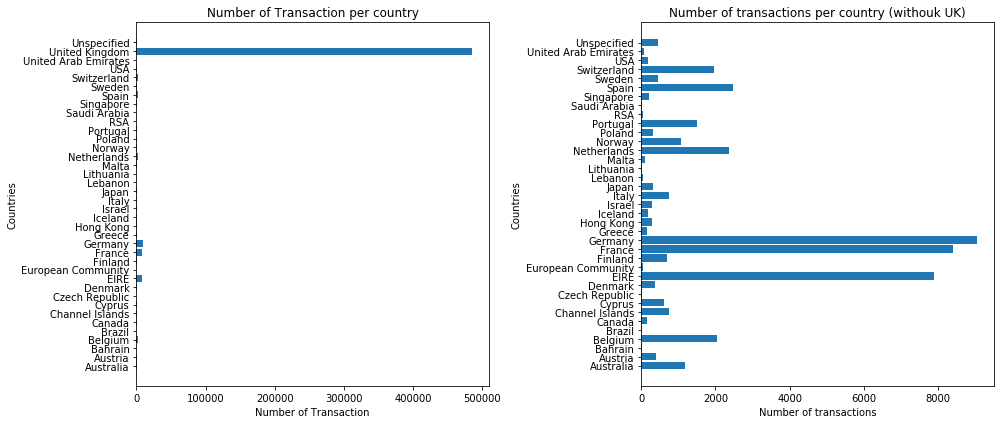

In [6]:
#visualization 
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

country_group = data[['Country','InvoiceNo']].groupby('Country').count()
country_group.sort_values('InvoiceNo', axis=0, ascending=False)

ax[0].barh(y=country_group.index,  width='InvoiceNo', data=country_group)
ax[0].set_ylabel('Countries')
ax[0].set_xlabel('Number of Transaction')
ax[0].set_title('Number of Transaction per country')

country_group = country_group[country_group.index != 'United Kingdom']

ax[1].barh(y = country_group.index, width = 'InvoiceNo', data = country_group[country_group.index != 'United Kingdom'])
ax[1].set_ylabel('Countries')
ax[1].set_xlabel('Number of transactions')
ax[1].set_title('Number of transactions per country (withouk UK)')

plt.tight_layout()

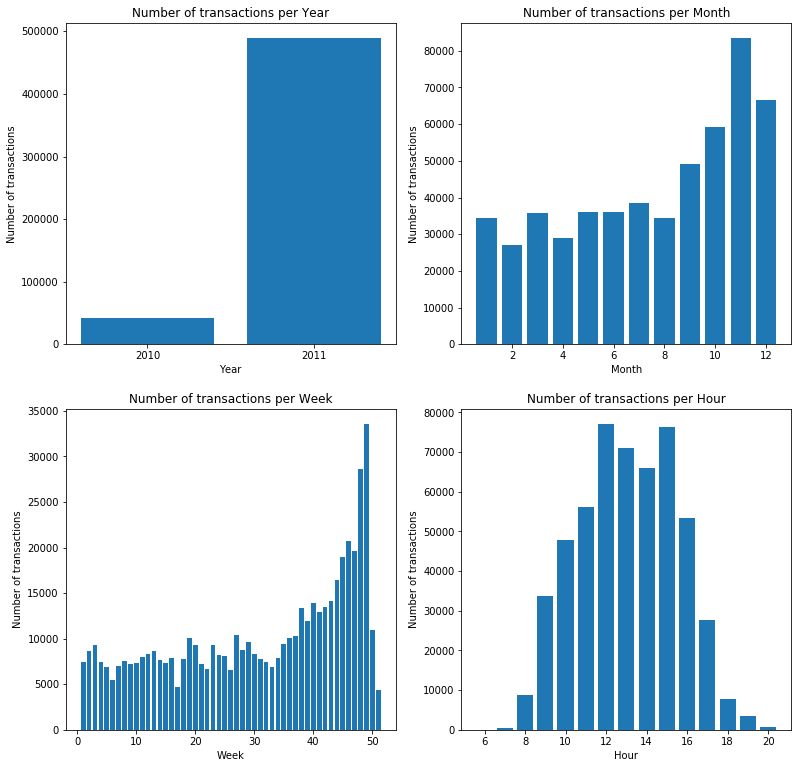

In [7]:
#plotting transaction year/month/day/week wise -
groups = np.array([['Year','Month'],['Week','Hour']])
fig, ax = plt.subplots(groups.shape[0], groups.shape[1], figsize=(13, 13))

for i in range(0, groups.shape[0]):
    for j in range(0, groups.shape[1]):
        grp_data = data[[groups[i,j], 'InvoiceNo']].groupby([groups[i,j]]).count()
        grp_data.reset_index(level=0, inplace=True)
        ax[i,j].bar(x = grp_data.iloc[:,0], height= 'InvoiceNo', data = grp_data, align='center')
        if groups[i,j] == 'Year':
            ax[i,j].set_xticks(grp_data.iloc[:, 0])
            ax[i,j].set_xticklabels(grp_data.iloc[:, 0])
        ax[i,j].set_ylabel('Number of transactions')
        ax[i,j].set_xlabel(groups[i,j])
        ax[i,j].set_title('Number of transactions per {}'.format(groups[i,j]))

plt.show()

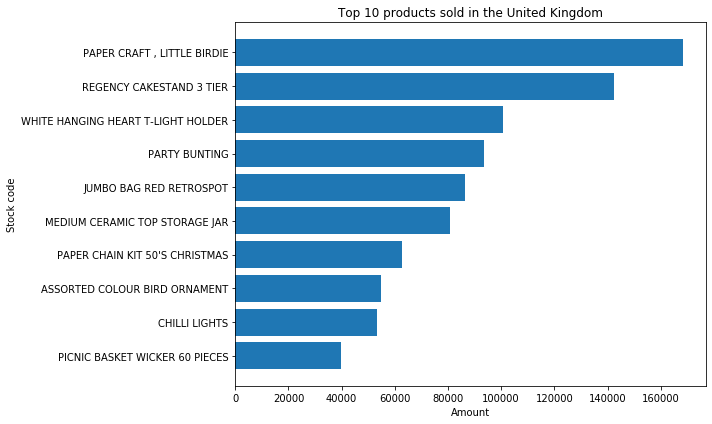

In [8]:
# filter unrelevant products
fltr = ['DOT', 'POST', 'M', 'DOTCOM POSTAGE', 'AMAZON FEE']
top_n = 10

fig, ax = plt.subplots(figsize=(10, 6))

grp_data = data[data['Country'] == 'United Kingdom']
grp_data = grp_data[~grp_data['Description'].isin(fltr)]
grp_data = grp_data[['Description', 'Amount']].groupby(['Description']).sum().sort_values(by='Amount', ascending=False)        
grp_data = grp_data[0:top_n]    
grp_data = grp_data.reset_index()

ax.barh(y=grp_data.index, width='Amount', data=grp_data)
ax.invert_yaxis()
ax.set_yticks(range(0,top_n))
ax.set_yticklabels(grp_data['Description'].tolist())
ax.set_ylabel('Stock code')        
ax.set_xlabel('Amount')                
ax.set_title('Top 10 products sold in the United Kingdom')
        
plt.tight_layout()
plt.show()

In [9]:
#creating Basket Dataframe
basket = data.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')
basket.head()

Description,*Boombox Ipod Classic,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
#Encoding
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)

In [14]:
#Calculation Association using Apriori Algorithm
frequent_itemsets = apriori(basket_sets, min_support = 0.04, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

# Selecting the important parameters for analysis
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head()

,antecedents,consequents,support,confidence,lift
0,(JUMBO BAG RED RETROSPOT),(JUMBO BAG PINK POLKADOT),0.041329,0.394926,6.472503
1,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.041329,0.677340,6.472503
